In [3]:
#Imports and dependencies
import os
from os.path import join
import torch
import torch.nn as nn
import math
import pandas as pd
import imageio
from skimage import img_as_ubyte
from scipy.ndimage.morphology import binary_dilation
from itertools import product
from typing import List
from tqdm import tqdm_notebook
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.renderer import (
    SfMPerspectiveCameras, OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights
)
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency
)
from dataclasses import dataclass, field, asdict, astuple
import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import time
from copy import deepcopy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from utils.visualization import plot_pointcloud
from utils.shapes import Sphere, SphericalSpiral
from utils.manager import RenderManager, ImageManager

['/home/ubuntu/E3D', '/home/ubuntu/E3D', '/home/ubuntu/anaconda3/envs/pytorch3d/lib/python37.zip', '/home/ubuntu/anaconda3/envs/pytorch3d/lib/python3.7', '/home/ubuntu/anaconda3/envs/pytorch3d/lib/python3.7/lib-dynload', '', '/home/ubuntu/anaconda3/envs/pytorch3d/lib/python3.7/site-packages', '/home/ubuntu/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/IPython/extensions', '/home/ubuntu/.ipython']


In [4]:
#Matplotlib config nums
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

### Load Object

In [5]:
#Load the object without textures and materials
verts, faces_idx, _ = load_obj("data/meshes/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/home/ubuntu/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


### Create a Renderer

In [6]:
cameras = SfMPerspectiveCameras(device=device)


# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=100, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights, cameras=cameras)
)

### Create a trajectory and Render

shaded


{'mesh_name': 'teapot', 'images': {'shaded': [{'posn': 0, 'image_path': 'data/renders/teapot_2020-07-14T21:06:16/shaded/0_shaded.png', 'render_type': 'shaded', 'R': [[[1.0, -2.6935497175815266e-17, -5.756689357679911e-17], [-4.494144729022259e-17, 0.3407922685146332, -0.9401386976242065], [4.494144729022259e-17, 0.9401386976242065, 0.3407922685146332]]], 'T': [[-0.0, -0.0, 2.891493082046509]], 'extension': 'png'}]}, 'R': [[[[1.0, -2.6935497175815266e-17, -5.756689357679911e-17], [-4.494144729022259e-17, 0.3407922685146332, -0.9401386976242065], [4.494144729022259e-17, 0.9401386976242065, 0.3407922685146332]]]], 'T': [[[-0.0, -0.0, 2.891493082046509]]], 'types': ['shaded'], 'metadata': {}, 'count': 1, 'folder_locs': {'base': 'data/renders/teapot_2020-07-14T21:06:16', 'shaded': 'data/renders/teapot_2020-07-14T21:06:16/shaded'}, 'formatted_utc_ts': '2020-07-14T21:06:16', 'gif_writers': {'shaded': 'data/renders/teapot_2020-07-14T21:06:16/shaded/camera_simulation_shaded.gif'}}


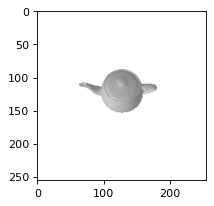

In [9]:
#Notes: benefit of having varying radiis for trajectory
#TODO: Move all the camera stuff to a dataclass

#Just to put these somewhere - this should be stored in param file after

def cam_trajectory_rotation(num_points: int = 1):
    """
    Returns: list of camera poses (R,T) from trajectory along a spherical spiral
    """
    
    #sphere = Sphere(
    #    radius=2,
    #    num_points_theta = 1,
    #    num_points_phi = 30,
    #    theta_min = math.pi/2,
    #    theta_max = math.pi/2, 
    #    phi_max = math.pi)
    shape = SphericalSpiral(
        c = 6.5,
        a = 1.5,
        t_min = .5*math.pi,
        t_max=.5*math.pi,
        num_points=num_points)
    up = torch.tensor([[0., 1., 1.]])
    R = []
    T = []
    for cp in shape._tuples:
        cp = torch.tensor(cp).to(device)
        R_new = look_at_rotation(cp[None, :],up=up, device=device)
        T_new = -torch.bmm(R_new.transpose(1,2), cp[None, :, None])[:, :, 0]
        if not len(R) and not len(T):
            R = [R_new]
            T = [T_new]
        else:
            R.append(R_new)
            T.append(T_new)
    return (R, T)

def cam_trajectory_transform(
    dist: float = 2.7,
    elev_range: list= [10, 50],
    azim_range: list= [-180, 180]):
    """
    Input
    Returns cameras from ranges of elevations and azimuths
    
    Not going to use this for now
    """
    
    elev = torch.linspace(elev_range[0], elev_range[1], batch_size)
    azim = torch.linspace(elev_range[0], elev_range[1], batch_size)
    R = []
    T = []
    for e, a in elev, azim:
        R_new, T_new = look_at_view_transform(dist=dist, elev=e, azim=a)
        R = torch.stack((R, R_new)) if R else R_new
        T = torch.stack((T, T_new)) if T else T_new
    return (R, T)
    
def render_trajectory(cam_poses, write_gif=True):
    
    """
    output_folder = "./data/renders/"
    
    silhouette_output = join(output_folder, "camera_simulation_silhouette.gif")
    silhouette_writer = imageio.get_writer(silhouette_output, mode="I", duration=.2)
    
    image_output = join(output_folder, "camera_simulation_image.gif")
    image_writer = imageio.get_writer(image_output, mode="I", duration=.2)
    """
    render_manager = RenderManager(
        types=["shaded"],
        mesh_name = "teapot"
    )
    # Render the teapot providing the values of R and T.
    R, T = cam_poses
    for num in range(len(R)):
        #gl_cam = OpenGLPerspectiveCameras(device=device, R=R, T=T)
        #sf_cam = SfMPerspectiveCameras(device=device, R=R, T=T)
        #silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R[num], T=T[num])
        image_ref = phong_renderer(meshes_world=teapot_mesh, R=R[num], T=T[num])
        
        #silhouette = silhouette.cpu().numpy()
        image_ref = image_ref.cpu().numpy()
        '''
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(silhouette.squeeze()[...,3])  # only plot the alpha channel of the RGBA image
        '''
        plt.grid(False)
        plt.subplot(1, 2, 2)
        plt.imshow(image_ref.squeeze())
        plt.grid(False)
        
        render_manager.add_images(
            num,
            {"shaded": image_ref.squeeze()}, 
            R[num], T[num])
        
    render_manager.close()
    return render_manager
    
cam_poses = cam_trajectory_rotation()
render = render_trajectory(cam_poses)

### Diff Model

In [10]:
def neg_iou_loss(predict, target):
    dims = tuple(range(predict.ndimension())[1:])
    intersect = (predict * target).sum(dims)
    union = (predict + target - predict * target).sum(dims) + 1e-6
    return 1. - (intersect / union).sum() / intersect.nelement()

In [41]:
class ImageBasedDifferentiableModel(nn.Module):
    
    def __init__(self, device, template_mesh = None):
        super().__init__()
        
        self.device = device
        
        #Create a source mesh
        if not template_mesh:
            template_mesh = ico_sphere(3, device)
        
        verts, faces = template_mesh.get_mesh_verts_faces(0)
        #Initialize each vert to have no tetxture
        verts_rgb = torch.ones_like(verts)[None]
        textures = Textures(verts_rgb=verts_rgb.to(self.device))
        self.template_mesh = Meshes(
            verts=[verts.to(self.device)],
            faces=[faces.to(self.device)],
            textures = textures
        )
        
        self.register_buffer('vertices', self.template_mesh.verts_padded())
        self.register_buffer('faces', self.template_mesh.faces_padded())
        self.register_buffer('textures', textures.verts_rgb_padded())
        
        deform_verts = torch.zeros_like(self.template_mesh.verts_packed(), device=device, requires_grad=True)
        deform_verts = torch.full(self.template_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
        #Create an optimizable parameter for the mesh
        self.register_parameter('deform_verts', nn.Parameter(deform_verts).to(self.device))
        
        laplacian_loss = mesh_laplacian_smoothing(template_mesh, method="uniform")
        flatten_loss = mesh_normal_consistency(template_mesh)
        
    def forward(self, batch_size):
        #Offset the mesh
        deformed_mesh_verts = self.template_mesh.offset_verts(self.deform_verts)
        texture = Textures(verts_rgb = self.textures)
        deformed_mesh = Meshes(verts=deformed_mesh_verts.verts_padded(), faces=deformed_mesh_verts.faces_padded(), textures=texture)
        deformed_mesh.extend(batch_size)
        
        laplacian_loss = mesh_laplacian_smoothing(deformed_mesh, method="uniform")
        flatten_loss = mesh_normal_consistency(deformed_mesh)
        
        return deformed_mesh, laplacian_loss, flatten_loss
    

### Initialize the model

In [57]:
weight_silhouette = 1
weight_laplacian = .001
weight_flatten = .00001

# We will save images periodically and compose them into a GIF.
filename_output = "./projection_loss.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

#Create a loss plotting object
#loss_ax = plot_loss(num_losses = 3)

# Initialize a model using the renderer, template mesh and reference image
model = ImageBasedDifferentiableModel(device).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=1) #Hyperparameter tuning

R, T = render._trajectory
images_gt = render._images().to(device)
cameras = SfMPerspectiveCameras(device=device, R=R, T=T)

### Run the optimization

/home/ubuntu/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


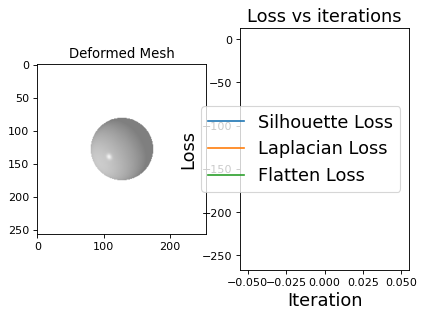

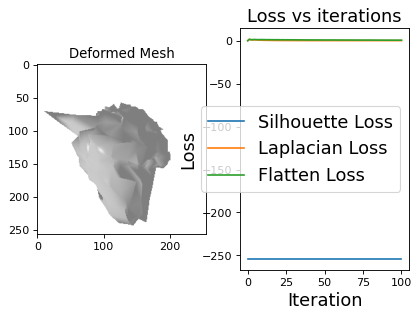

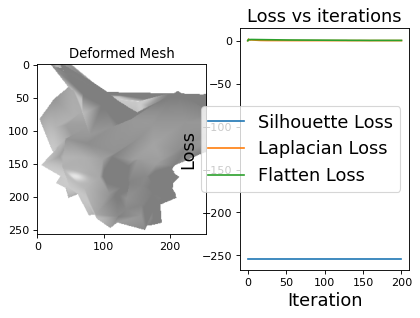

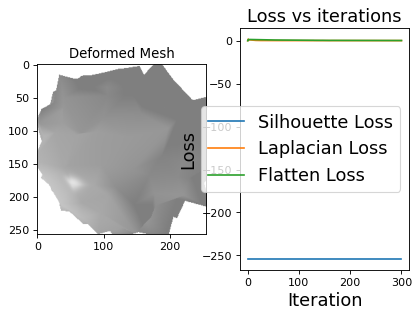

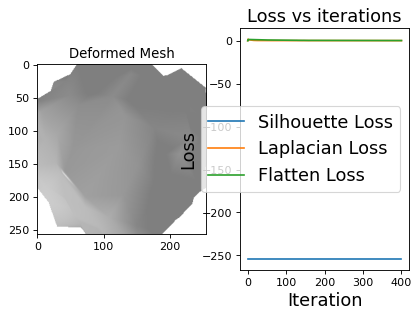

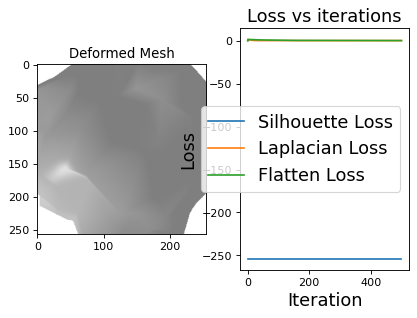

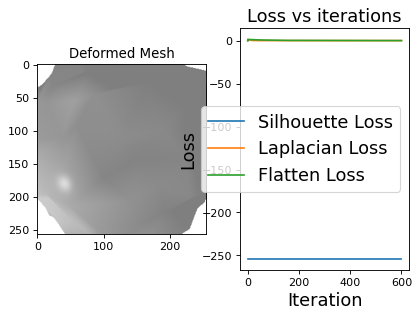

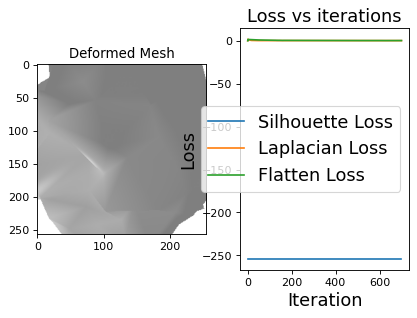

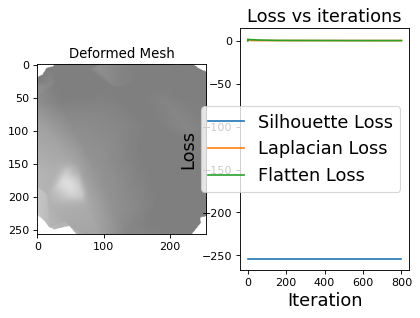

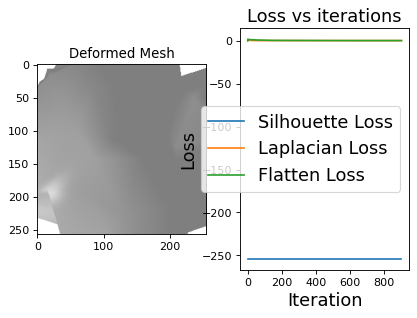

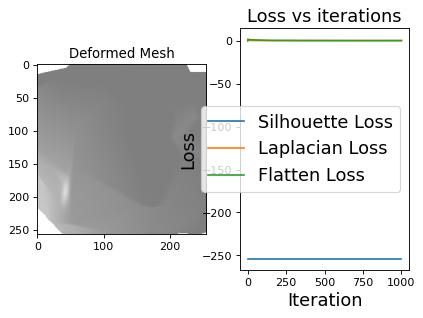

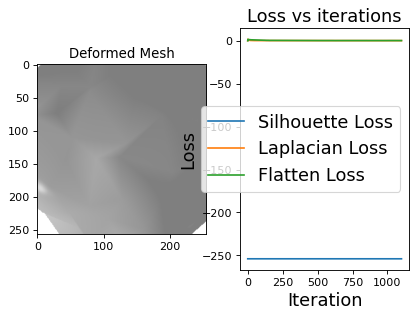

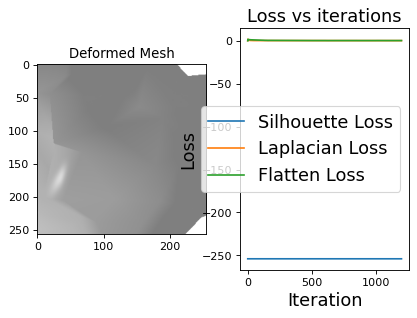

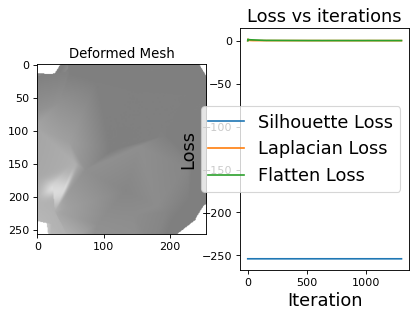

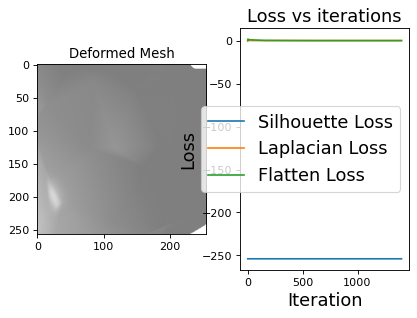

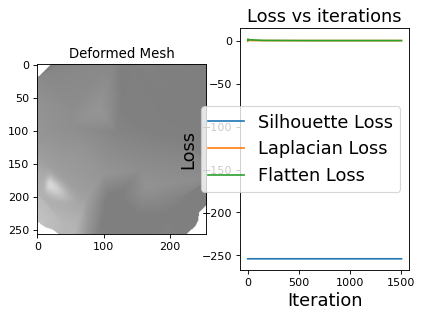

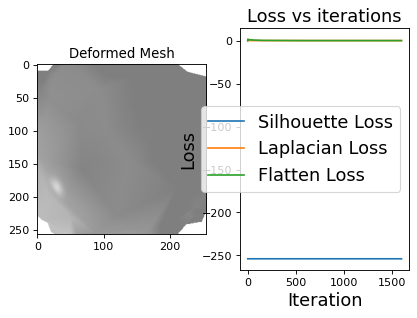

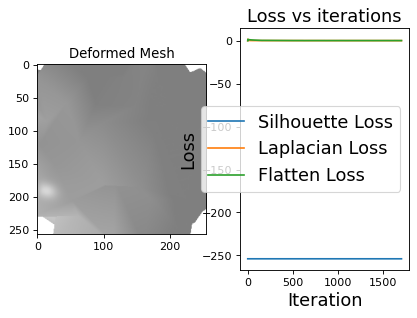

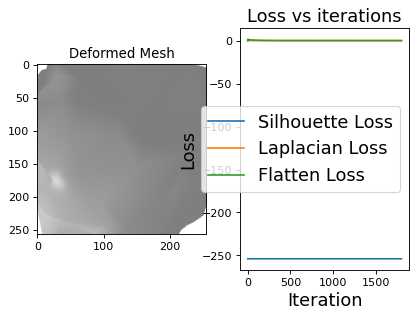

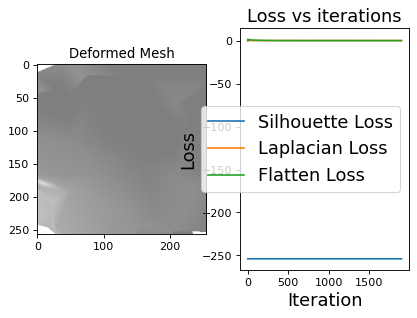

In [58]:
loop = tqdm_notebook(range(2000))
laplacian_losses = []
flatten_losses = []
silhouette_losses = []
for i in loop:
    
    mesh, laplacian_loss, flatten_loss = model(len(images_gt))
    
    images_pred = phong_renderer(mesh.clone(), device=device, cameras=cameras)
    
    silhouette_loss = neg_iou_loss(images_pred[..., 3], images_gt[...,3])
    #ssd_loss = torch.sum((images_pred[...,3] - images_gt) ** 2)
    
    loss = silhouette_loss * weight_silhouette + laplacian_loss * weight_laplacian + flatten_loss * weight_flatten
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    silhouette_losses.append(silhouette_loss)
    laplacian_losses.append(laplacian_loss)
    flatten_losses.append(flatten_loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        #Write images
        image = images_pred.detach().cpu().numpy()[0]
        writer.append_data((255*image).astype(np.uint8))
        imageio.imsave(f"data/dump/mesh_{i}.png", (255*image).astype(np.uint8))
        
        f, (ax1, ax2) = plt.subplots(1, 2)
        
        image = img_as_ubyte(image)
        ax1.imshow(image)
        ax1.set_title("Deformed Mesh")
        
        ax2.plot(silhouette_losses, label="Silhouette Loss")
        ax2.plot(laplacian_losses, label="Laplacian Loss")
        ax2.plot(flatten_losses, label="Flatten Loss")
        ax2.legend(fontsize="16")
        ax2.set_xlabel("Iteration", fontsize="16")
        ax2.set_ylabel("Loss", fontsize="16")
        ax2.set_title("Loss vs iterations", fontsize="16")
        
        plt.show()
    

In [59]:
print(images_pred)

tensor([[[[0.5000, 0.5000, 0.5000, 1.0000],
          [0.5000, 0.5000, 0.5000, 1.0000],
          [0.5000, 0.5000, 0.5000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]],

         [[0.5000, 0.5000, 0.5000, 1.0000],
          [0.5000, 0.5000, 0.5000, 1.0000],
          [0.5000, 0.5000, 0.5000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]],

         [[0.5000, 0.5000, 0.5000, 1.0000],
          [0.5000, 0.5000, 0.5000, 1.0000],
          [0.5000, 0.5000, 0.5000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000]],

         ...,

         [[0.7811, 0.7811, 0.7811, 1.0000],
          [0.7809, 0.7809, 0.7809, 1.0000],
          [0.7805, 0.7805, 0.7805, 1.0000],
          

In [60]:
print(images_gt)

tensor([[[254.9745, 254.9745, 254.9745,  ..., 254.9745, 254.9745, 254.9745],
         [254.9745, 254.9745, 254.9745,  ..., 254.9745, 254.9745, 254.9745],
         [254.9745, 254.9745, 254.9745,  ..., 254.9745, 254.9745, 254.9745],
         ...,
         [254.9745, 254.9745, 254.9745,  ..., 254.9745, 254.9745, 254.9745],
         [254.9745, 254.9745, 254.9745,  ..., 254.9745, 254.9745, 254.9745],
         [254.9745, 254.9745, 254.9745,  ..., 254.9745, 254.9745, 254.9745]]],
       device='cuda:0', dtype=torch.float64)
